# Final Capstone Project

### Business Problem:

   Using data on the venues present in different neighborhoods of Atlanta, GA combined with average rent of each neighborhood. We will train a linear regression model to predict rent prices of a neighborhood. This problem will require the use of Foursquare API to get local venues as well as data about rent and neighborhood location which will be aquired through various sources. This report should interest developers and landlords wondering where to build or how much to charge for rent as well as renters who are looking for a place to rent and are interested in how much is fair rent. Finally this report will also interest city officials who will be able to gain insight on certian venues effects on neighborhood rent.

### Backgroud:

   The neighborhoods that comprise the city of Atlanta are rich with history. Atlanta was the home of many civil rights leaders such as John Lewis, Ralph David Abernathy, Dr. Martin Luther King Jr, and many more. The neighborhoods they resided in are decorated with tributes to their historic neighbors. However the neighborhoods of Atlanta have also been shaped by its less glamourous history. During the American Civil War Atlanta was a crucial stronghold of the confederacy due to the multiple railroads that intersected within the city making the city crucial for sending supplies to confederate troops throughout the South East. In 1864 during the Union Army's "March to the Sea" led by General William Sherman the city of Atlanta was burnt down (with some help from the retreating confederates) and it's residents displaced. After the Civil War ended in 1865, Atlanta began its rebuilding process which was accelerated due to the cities extensive railroad network. This rebuilding led to a boom in the city's population and the city of Atlanta was made the capital city of Georgia soon after. The city experienced significant growth through the late 1800's and early 1900's however racial tensions and Jim Crow laws would make a lasting mark on the city. In 1906 the Atlanta Race Riots forced black residents out of the booming Downtown Atlanta into the Sweet Auburn neighborhood which remains a predominantly black neighborhood to this day. Further red lining and segregation led to some very noticable differences throughout the neighborhoods such as roads being renamed as they pass through historically "Black" or "White" neighborhoods (i.e. Boulevard becoming Monroe and Moreland becoming Braircliff). After sustained growth through the 20th century including the construction of the world's busiest airport in south Atlanta, several interstates that pass through the city, establishing of universities within the city such as Georgia Tech, Morehouse, Emory University. The huge growth of Atlanta throughout the 20th century was capstoned with the 1996 Summer Olympics being hosted in the city. Current day Atlanta is composed of an incredibly diverse, well-educated, and young population which has grown over 24% in the last decade making it one of the fastest growing cities in the U.S. 

### Data

   The Data that will be used to approach this problem will come from [RentCafe](https://www.rentcafe.com/average-rent-market-trends/us/ga/atlanta/) for the average rent per neighborhood, Geopy for the latitude and longitude data, and finally the Foursquare API to get venue data.  

#### Constructing Average Rent Dataframe

In [110]:
import pandas as pd
import numpy as np
from selenium import webdriver
from time import sleep
import requests

ModuleNotFoundError: No module named 'matplotlip'

In [37]:
# creating lists
neighborhoods = []
rents = []

# initializing chrome driver and opening wikipedia page
browser = webdriver.Chrome()
browser.get('https://www.rentcafe.com/average-rent-market-trends/us/ga/atlanta/')
sleep(5)

# View all table cells
cookie = browser.find_element_by_xpath("//*[@id='cookieinfopolicy']/div")
cookie.click()
veiw_all = browser.find_element_by_xpath("//*[@id='MarketTrendsAverageRentTableFullView']")
veiw_all.click()

# locating table columns by xpath
neighbor = browser.find_elements_by_xpath("//*[@id='MarketTrendsAverageRentTable']//*[@class='current-row']/th")
rent = browser.find_elements_by_xpath("//*[@id='MarketTrendsAverageRentTable']//*[@class='current-row']/td")
print(len(neighbor))
print(len(rent))

# copying data of first column to neighborhoods list
for i in neighbor:
    neighborhoods.append(i.text)
    
# copying data of second column to rents list
for i in rent:
    rents.append(i.text)

browser.close()

# combining lists created above
lst = zip(neighborhoods, rents)

# creating dataframe containing list data
df = pd.DataFrame(lst, columns = ["Neighborhood", "Avg. Rent"])
df

632
632


,Neighborhood,Avg. Rent
0,Ansley Park,"$2,046"
1,Ardmore,"$2,046"
2,Brookwood Hills,"$2,046"
3,Collier Hills North,"$2,046"
4,Colonial,"$2,046"
...,...,...
627,Pomona Park,$950
628,Regency Point,$950
629,Southwest Atlanta,$950
630,Sunridge Construction,$950


#### Getting Latitude and Longitude of each neighborhood

In [38]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Atlanta_rent")

lat = []
long = []

# Use geopy to get Lat, Long for each neighborhood
for i in neighborhoods:
    try:
        location = geolocator.geocode(i + ", Atlanta, GA")
        lat.append(location.latitude)
        long.append(location.longitude)
    except AttributeError:
        # if no 
        lat.append(np.nan)
        long.append(np.nan)
        pass

lst = zip(neighborhoods, lat, long)

# creating dataframe containing list data
lat_long_atlanta = pd.DataFrame(lst, columns = ["Neighborhood", "Latitude", "Longitude"])
lat_long_atlanta

,Neighborhood,Latitude,Longitude
0,Ansley Park,33.794550,-84.376315
1,Ardmore,33.806282,-84.400028
2,Brookwood Hills,33.807883,-84.390205
3,Collier Hills North,NaN,NaN
4,Colonial,33.814009,-84.395760
...,...,...,...
627,Pomona Park,NaN,NaN
628,Regency Point,-7.745800,110.357041
629,Southwest Atlanta,45.004757,-84.151970
630,Sunridge Construction,NaN,NaN


#### Combine and Clean data

In [41]:
new_df = pd.merge(df, lat_long_atlanta, on="Neighborhood", how="inner")
new_df

,Neighborhood,Avg. Rent,Latitude,Longitude
0,Ansley Park,"$2,046",33.794550,-84.376315
1,Ardmore,"$2,046",33.806282,-84.400028
2,Brookwood Hills,"$2,046",33.807883,-84.390205
3,Collier Hills North,"$2,046",NaN,NaN
4,Colonial,"$2,046",33.814009,-84.395760
...,...,...,...,...
637,Pomona Park,$950,NaN,NaN
638,Regency Point,$950,-7.745800,110.357041
639,Southwest Atlanta,$950,45.004757,-84.151970
640,Sunridge Construction,$950,NaN,NaN


After combining the data sets I need to deal with missing values. With the code below I can see that Latitude and Longitude are missing 452 out of 642 values

In [44]:
len(new_df["Neighborhood"].unique())
missing_data = new_df.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")   

Neighborhood
False    642
Name: Neighborhood, dtype: int64

Avg. Rent
False    642
Name: Avg. Rent, dtype: int64

Latitude
True     452
False    190
Name: Latitude, dtype: int64

Longitude
True     452
False    190
Name: Longitude, dtype: int64



In [46]:
# drop rows with NaN in "Latitude" column
new_df.dropna(subset=["Latitude"], axis=0, inplace=True)

# drop rows with NaN in "Longitude" column
new_df.dropna(subset=["Longitude"], axis=0, inplace=True)

# reset index
new_df.reset_index(drop=True, inplace=True)
new_df

,Neighborhood,Avg. Rent,Latitude,Longitude
0,Ansley Park,"$2,046",33.794550,-84.376315
1,Ardmore,"$2,046",33.806282,-84.400028
2,Brookwood Hills,"$2,046",33.807883,-84.390205
3,Colonial,"$2,046",33.814009,-84.395760
4,Piedmont Park,"$2,046",33.789048,-84.371886
...,...,...,...,...
185,Cascade Heights,$950,33.722330,-84.463263
186,Cascade Road,$950,33.720639,-84.469215
187,Ivan Hill,$950,33.764858,-84.389215
188,Regency Point,$950,-7.745800,110.357041


Now that I have removed all the missing values, I am looking for incorrect location values by finding outliers in terms of distance from Atlanta

In [47]:
atlanta_lat = 33.753746
atlanta_long = -84.386330

# Calculating Distance from the center of Atlanta
new_df["Distance From ATL"] = ((new_df["Latitude"]-atlanta_lat)**2 + (new_df["Longitude"]-atlanta_long)**2)**0.5
new_df

,Neighborhood,Avg. Rent,Latitude,Longitude,Distance From ATL
0,Ansley Park,"$2,046",33.794550,-84.376315,0.042015
1,Ardmore,"$2,046",33.806282,-84.400028,0.054293
2,Brookwood Hills,"$2,046",33.807883,-84.390205,0.054275
3,Colonial,"$2,046",33.814009,-84.395760,0.060996
4,Piedmont Park,"$2,046",33.789048,-84.371886,0.038142
...,...,...,...,...,...
185,Cascade Heights,$950,33.722330,-84.463263,0.083100
186,Cascade Road,$950,33.720639,-84.469215,0.089252
187,Ivan Hill,$950,33.764858,-84.389215,0.011480
188,Regency Point,$950,-7.745800,110.357041,199.116029


In [52]:
new_df["Distance From ATL"].describe()

count    190.000000
mean       3.099603
std       17.372591
min        0.002349
25%        0.046797
50%        0.072657
75%        0.136748
max      199.116029
Name: Distance From ATL, dtype: float64

Removing outlier distances from data set. This will result in a data set in which every neighborhood is within a moderate distance of the center of Atlanta

In [82]:
# Defining an outlier as anything greater than 1.5 * 75th percentile
outlier = 0.136748 * 1.5

indexes = new_df[new_df["Distance From ATL"] > outlier].index
new_df.drop(indexes, inplace=True)
clean_df = new_df.drop_duplicates()
clean_df.reset_index(drop=True)

,Neighborhood,Avg. Rent,Latitude,Longitude,Distance From ATL
0,Ansley Park,"$2,046",33.794550,-84.376315,0.042015
1,Ardmore,"$2,046",33.806282,-84.400028,0.054293
2,Brookwood Hills,"$2,046",33.807883,-84.390205,0.054275
3,Colonial,"$2,046",33.814009,-84.395760,0.060996
4,Piedmont Park,"$2,046",33.789048,-84.371886,0.038142
...,...,...,...,...,...
155,Adams Park,$950,33.712052,-84.456873,0.081943
156,Campbellton Road,$950,33.693159,-84.517901,0.144851
157,Cascade Heights,$950,33.722330,-84.463263,0.083100
158,Cascade Road,$950,33.720639,-84.469215,0.089252


#### Find Venue Information per Neighborhood

In [71]:
# @hidden cell
CLIENT_ID = 'RD3GK2KL021H3ZNCPR1R0XA3FP3MIC1KYTKBF3NTNO43NL0X' # your Foursquare ID
CLIENT_SECRET = 'QD44DA4ZVUNOP3LXU0EBWBEMWMPZVGSWZAAVVZVWFAUDLJ3Q' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [73]:
def getNearbyVenues(names, latitudes, longitudes, rents, radius=500):
    
    venues_list=[]
    for name, lat, lng, rent in zip(names, latitudes, longitudes, rents):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            rent,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Neighborhood Rent',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [83]:
# gets 100 nearby venues in each neighborhood
atlanta_venues = getNearbyVenues(names=new_df['Neighborhood'],
                                   latitudes= clean_df['Latitude'],
                                   longitudes=clean_df['Longitude'],
                                   rents=clean_df['Avg. Rent']
                                  )

Ansley Park
Ardmore
Brookwood Hills
Colonial
Piedmont Park
Lenox
Atlantic Station
Buckhead Forest
Buckhead Village
Peachtree Hills
Midtown Atlanta
Atlanta Memorial Park
Brookwood
Brookwood
Brookwood
Brookwood
Loring Heights
Atkins Park
Virginia Highland
Virginia Park Townhomes
Downtown Atlanta
Springlake
Virgilee Park
Candler Park
Inman Park
Lake Claire
Little Five Points
Lullwater
Oakland
Sweet Auburn
Castleberry Hill
Brandon
Castlewood
Margaret Mitchell
Paces
Bellwood Quarry
Bolton
Carey Park
Collier Heights
Collier Hills
Dupont Commons
Hills Park
Ridgewood Heights
Riverside
Riverside
Riverside
Riverside
Rockdale
Underwood Hills
Westover Plantation
Wildwood
Georgia Tech
Edgewood
Cabbagetown
Dunwoody Springs
Foxcroft
Glenview
Hammond Hills
Armour
Lindbergh
Reynoldstown
Bankhead
Center Hill
Grove Park
Stonewall
Woodland Hills
Woodland Hills
Woodland Hills
Woodland Hills
Benteen Park
Grant Park
Mechanicsville
Summerhill
East Atlanta
Ormewood Park
Chastain
Northland Ridge
The Glenridge
E

In [87]:
atlanta_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Rent,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ansley Park,33.794550,-84.376315,"$2,046",Piedmont Atlanta BeltLine Sort-of-Urban Dare,33.792436,-84.373845,Trail
1,Ansley Park,33.794550,-84.376315,"$2,046",Cascades Garden,33.791002,-84.373586,Garden
2,Ansley Park,33.794550,-84.376315,"$2,046",Eclectic Bistro & Bar,33.793401,-84.372352,Bistro
3,Ansley Park,33.794550,-84.376315,"$2,046",Boy Next Door,33.794011,-84.371972,Men's Store
4,Ansley Park,33.794550,-84.376315,"$2,046",The Prado,33.792357,-84.373797,Miscellaneous Shop
...,...,...,...,...,...,...,...,...
2312,Providence Place,33.764858,-84.389215,$950,Caribou Coffee,33.762592,-84.385392,Coffee Shop
2313,Providence Place,33.764858,-84.389215,$950,Starbucks,33.761693,-84.385642,Coffee Shop
2314,Providence Place,33.764858,-84.389215,$950,Dunkin',33.762788,-84.385439,Donut Shop
2315,Providence Place,33.764858,-84.389215,$950,Folk Art Park At Ralph Mcgill & Courtland,33.764520,-84.384341,Sculpture Garden


In [250]:
# one hot encoding
atlanta_onehot = pd.get_dummies(atlanta_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood and rent columns back to dataframe
atlanta_onehot['Neighborhood'] = atlanta_venues['Neighborhood']
atlanta_onehot['Neighborhood Rent'] = atlanta_venues['Neighborhood Rent']

# moves Neighborhood and Neighborhood Rent to front of DF
cols_at_front = ['Neighborhood', 'Neighborhood Rent']
atlanta_onehot = atlanta_onehot[[c for c in cols_at_front if c in atlanta_onehot] + [c for c in atlanta_onehot if c not in cols_at_front]]

atlanta_onehot

,Neighborhood,Neighborhood Rent,ATM,Accessories Store,Adult Education Center,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,...,Warehouse Store,Waste Facility,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Ansley Park,"$2,046",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ansley Park,"$2,046",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ansley Park,"$2,046",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ansley Park,"$2,046",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ansley Park,"$2,046",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2312,Providence Place,$950,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2313,Providence Place,$950,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2314,Providence Place,$950,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2315,Providence Place,$950,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [256]:
# gets frequency of venue per neighborhood as an average value of venue type
atlanta_grouped = atlanta_onehot.groupby(['Neighborhood', 'Neighborhood Rent']).mean().reset_index()
atlanta_grouped

,Neighborhood,Neighborhood Rent,ATM,Accessories Store,Adult Education Center,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,...,Warehouse Store,Waste Facility,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Adair Park,"$1,002",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Adamsville,"$1,116",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Amhurst,"$1,002",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ansley Park,"$2,046",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ardmore,"$2,046",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Westview Cemetery,"$1,002",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136,Wildwood,"$1,541",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,Wildwood East,"$1,040",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138,Woodland Hills,"$1,447",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [257]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(axis=0,ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood', 'Neighborhood Rent']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = atlanta_grouped['Neighborhood']
neighborhoods_venues_sorted['Neighborhood Rent'] = atlanta_grouped['Neighborhood Rent']

for ind in np.arange(atlanta_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(atlanta_grouped.iloc[ind, :], num_top_venues)

# resulting data frame contains each neighborhood and their 10 most common venue types
neighborhoods_venues_sorted.head()

,Neighborhood,Neighborhood Rent,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adair Park,"$1,002",General Travel,Gaming Cafe,Zoo Exhibit,Field,Financial or Legal Service,Fish & Chips Shop,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop
1,Adamsville,"$1,116",Park,Pool,General Entertainment,Plaza,Playground,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
2,Amhurst,"$1,002",Grocery Store,Mexican Restaurant,Park,Shipping Store,Gym / Fitness Center,Pet Store,Sandwich Place,Pharmacy,Breakfast Spot,Fondue Restaurant
3,Ansley Park,"$2,046",Bistro,Men's Store,Garden,Miscellaneous Shop,Flower Shop,Trail,Field,Financial or Legal Service,Fish & Chips Shop,Fondue Restaurant
4,Ardmore,"$2,046",Gym,Park,Pool,Food Truck,Photography Studio,Trail,Food Court,Food & Drink Shop,Food,Fondue Restaurant


#### Model Building

Since I want to build a regression model to predict rent prices, I will need to use numeric values for my parameters instead of Strings such as the type of most common venue. To do this I will clean and use the frequency table as my main source of training and testing data

In [258]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns

In [259]:
test = atlanta_grouped
test

,Neighborhood,Neighborhood Rent,ATM,Accessories Store,Adult Education Center,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,...,Warehouse Store,Waste Facility,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Adair Park,"$1,002",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Adamsville,"$1,116",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Amhurst,"$1,002",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ansley Park,"$2,046",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ardmore,"$2,046",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Westview Cemetery,"$1,002",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136,Wildwood,"$1,541",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,Wildwood East,"$1,040",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138,Woodland Hills,"$1,447",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 Looking for the most frequent venues in Atlanta in order to determine which venues will be most useful in my regression analysis


In [260]:
# Selecting just the list of venues and frequencies from atlanta_grouped dataframe
x = test.loc[:,'ATM':]

# Taking the average frequency per venue across all neighborhoods and sorting from most to least
x = x.agg("mean", axis=0)
x.sort_values(ascending=False, inplace=True)
x

Park                       0.090030
Gym / Fitness Center       0.032938
Gym                        0.032216
Trail                      0.021508
American Restaurant        0.020464
                             ...   
Science Museum             0.000092
Skating Rink               0.000092
Health Food Store          0.000092
North Indian Restaurant    0.000071
Greek Restaurant           0.000071
Length: 290, dtype: float64

In [261]:
x.describe()

count    290.000000
mean       0.003446
std        0.006867
min        0.000071
25%        0.000408
50%        0.001507
75%        0.003571
max        0.090030
dtype: float64

Using the description statistics above I can figure out which venues will be most beneficial in my regression analysis by eliminating the venues that do not appear frequently enough to have a noticable effect. One downside of this process is there are venues such as sport stadiums or large parks that are not frequent but have a great effect on rent prices in the area.

In [262]:
# Removing any venues that are less frequent then the bottom 75th percentile
outlier = 0.003571

indexes = x[x < outlier].index
x.drop(indexes, inplace=True)
frequent_venues = x.drop_duplicates()
frequent_venues = frequent_venues.reset_index(drop=False)
frequent_venues.rename(columns={"index": "Venue", 0 : "Frequency"}, inplace=True)
frequent_venues

,Venue,Frequency
0,Park,0.090030
1,Gym / Fitness Center,0.032938
2,Gym,0.032216
3,Trail,0.021508
4,American Restaurant,0.020464
...,...,...
62,Shipping Store,0.003903
63,Furniture / Home Store,0.003796
64,Music Venue,0.003759
65,Garden,0.003651


In [313]:
# creates new dataframe called atlanta frequent which shows every venues frequency per neighborhood
# using only the venues that are the most frequent throughout the city (>= 75th percentile)
keep = frequent_venues.loc[:,"Venue"]
atlanta_frequent = test[[c for c in keep if c in test]]
atlanta_frequent

,Park,Gym / Fitness Center,Gym,Trail,American Restaurant,Gas Station,Sandwich Place,BBQ Joint,Business Service,Wings Joint,Arts & Entertainment,Coffee Shop,Pool,Discount Store,Pizza Place,Fast Food Restaurant,Bakery,Dance Studio,Breakfast Spot,Hotel,Mexican Restaurant,Ice Cream Shop,Southern / Soul Food Restaurant,Art Gallery,Pharmacy,Restaurant,Basketball Court,Food Truck,Bar,Seafood Restaurant,Chinese Restaurant,Cosmetics Shop,Intersection,Nightclub,Italian Restaurant,Moving Target,Grocery Store,Recreation Center,Café,Fried Chicken Joint,Cemetery,Golf Course,Liquor Store,Beach,Pet Store,Food,Home Service,Yoga Studio,Flower Shop,Tennis Court,Lounge,New American Restaurant,Clothing Store,Candy Store,Spa,Shopping Plaza,Caribbean Restaurant,Supermarket,Taco Place,Burger Joint,Storage Facility,Track,Shipping Store,Furniture / Home Store,Music Venue,Garden,Other Great Outdoors
0,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.00,0.00,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0
1,0.428571,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.00,0.00,0.0,0.0,0.000000,0.142857,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0
2,0.111111,0.111111,0.000000,0.000000,0.0,0.00,0.111111,0.00,0.00,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.111111,0.000000,0.111111,0.00,0.00,0.00,0.111111,0.00,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.111111,0.00,0.00,0.000000,0.0
3,0.000000,0.000000,0.000000,0.166667,0.0,0.00,0.000000,0.00,0.00,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.00,0.00,0.166667,0.0
4,0.181818,0.000000,0.272727,0.090909,0.0,0.00,0.000000,0.00,0.00,0.0,0.0,0.000000,0.181818,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,0.181818,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.000000,0.000000,0.333333,0.000000,0.0,0.00,0.000000,0.00,0.00,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0
136,0.000000,0.037037,0.000000,0.000000,0.0,0.00,0.074074,0.00,0.00,0.0,0.0,0.037037,0.000000,0.00,0.037037,0.037037,0.00,0.00,0.000000,0.148148,0.000000,0.00,0.00,0.00,0.074074,0.00,0.0,0.037037,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.037037,0.0,0.0,0.0,0.00,0.037037,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0
137,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.0

In [314]:
# adding Neighborhood and Neighborhood Rent back into data frame
atlanta_frequent.insert(0, "Neighborhood Rent", atlanta_grouped.loc[:, "Neighborhood Rent"])
atlanta_frequent.insert(0, "Neighborhood", atlanta_grouped.loc[:, "Neighborhood"])
atlanta_frequent

,Neighborhood,Neighborhood Rent,Park,Gym / Fitness Center,Gym,Trail,American Restaurant,Gas Station,Sandwich Place,BBQ Joint,Business Service,Wings Joint,Arts & Entertainment,Coffee Shop,Pool,Discount Store,Pizza Place,Fast Food Restaurant,Bakery,Dance Studio,Breakfast Spot,Hotel,Mexican Restaurant,Ice Cream Shop,Southern / Soul Food Restaurant,Art Gallery,Pharmacy,Restaurant,Basketball Court,Food Truck,Bar,Seafood Restaurant,Chinese Restaurant,Cosmetics Shop,Intersection,Nightclub,Italian Restaurant,Moving Target,Grocery Store,Recreation Center,Café,Fried Chicken Joint,Cemetery,Golf Course,Liquor Store,Beach,Pet Store,Food,Home Service,Yoga Studio,Flower Shop,Tennis Court,Lounge,New American Restaurant,Clothing Store,Candy Store,Spa,Shopping Plaza,Caribbean Restaurant,Supermarket,Taco Place,Burger Joint,Storage Facility,Track,Shipping Store,Furniture / Home Store,Music Venue,Garden,Other Great Outdoors
0,Adair Park,"$1,002",0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.00,0.00,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0
1,Adamsville,"$1,116",0.428571,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.00,0.00,0.0,0.0,0.000000,0.142857,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0
2,Amhurst,"$1,002",0.111111,0.111111,0.000000,0.000000,0.0,0.00,0.111111,0.00,0.00,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.111111,0.000000,0.111111,0.00,0.00,0.00,0.111111,0.00,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.111111,0.00,0.00,0.000000,0.0
3,Ansley Park,"$2,046",0.000000,0.000000,0.000000,0.166667,0.0,0.00,0.000000,0.00,0.00,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.00,0.00,0.166667,0.0
4,Ardmore,"$2,046",0.181818,0.000000,0.272727,0.090909,0.0,0.00,0.000000,0.00,0.00,0.0,0.0,0.000000,0.181818,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,0.181818,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Westview Cemetery,"$1,002",0.000000,0.000000,0.333333,0.000000,0.0,0.00,0.000000,0.00,0.00,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.00,0.00,0.0,0.0,0.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0
136,Wildwood,"$1,541",0.000000,0.037037,0.000000,0.000000,0.0,0.00,0.074074,0.00,0.00,0.0,0.0,0.037037,0.000000,0.00,0.037037,0.037037,0.00,0.00,0.000000,0.148148,0.000000,0.00,0.00,0.00,0.074074,0.00,0.0,0.037037,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

Now that I have each neighborhood, the average rent in the neighborhood, and the frequency of Atlanta's most common venues in each neighborhood, I can now start to develop my regression model. Since I am using several variables to evaluate average rent prices I need to determine which variables would be the most effective. I do not want to use too many variables since that may result in overfitting of my model.

In [329]:
# Converts Neighborhood Rent from String to Float by removing '$'
atlanta_frequent.loc[:,"Neighborhood Rent"] = atlanta_frequent["Neighborhood Rent"].replace('[\$,]', '', regex=True).astype(int)
corr = atlanta_frequent.corr()

# Isolating the correlations for Neighborhood Rent and taking the absolute value inorder to sort by magnitude of correlation
rent_corr = corr["Neighborhood Rent"].abs()
rent_corr.sort_values(ascending=False)

Neighborhood Rent    1.000000
Garden               0.269475
Bar                  0.233320
Flower Shop          0.228867
Clothing Store       0.217972
                       ...   
Golf Course          0.014881
Supermarket          0.008397
Restaurant           0.006311
Liquor Store         0.005254
Home Service         0.001718
Name: Neighborhood Rent, Length: 68, dtype: float64

In [330]:
rent_corr.describe()

count    68.000000
mean      0.106599
std       0.126134
min       0.001718
25%       0.051641
50%       0.085002
75%       0.123723
max       1.000000
Name: Neighborhood Rent, dtype: float64

In [338]:
# Removing any venues that have less of a correlation than the 75th percentile of venues
outlier = 0.123723

indexes = rent_corr[rent_corr < outlier].index
rent_corr.drop(indexes, inplace=True)
rent_corr_cleaned = rent_corr.drop_duplicates()
rent_corr_cleaned = rent_corr_cleaned.reset_index(drop=False)
rent_corr_cleaned = rent_corr_cleaned.rename(columns={"index" : "Venue Type", "Neighborhood Rent": "Correlation"})
rent_corr_cleaned.loc[1:,:]

,Venue Type,Correlation
1,BBQ Joint,0.153705
2,Wings Joint,0.177765
3,Discount Store,0.162284
4,Pizza Place,0.138658
5,Southern / Soul Food Restaurant,0.146067
6,Bar,0.233320
7,Fried Chicken Joint,0.136557
8,Yoga Studio,0.204332
9,Flower Shop,0.228867
10,New American Restaurant,0.184607


The List above represents the top 25% of venues which have the largest affect on rent prices in a given neighborhood whether that correlation is positive or negative.

In [343]:
atlanta_frequent = atlanta_frequent.loc[:, rent_corr_cleaned["Venue Type"]]
atlanta_frequent

,Neighborhood Rent,BBQ Joint,Wings Joint,Discount Store,Pizza Place,Southern / Soul Food Restaurant,Bar,Fried Chicken Joint,Yoga Studio,Flower Shop,New American Restaurant,Clothing Store,Taco Place,Burger Joint,Shipping Store,Music Venue,Garden
0,1002,0.00,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000
1,1116,0.00,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000
2,1002,0.00,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,0.000000,0.111111,0.00,0.000000
3,2046,0.00,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.166667,0.00,0.00,0.00,0.000000,0.000000,0.00,0.166667
4,2046,0.00,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,1002,0.00,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000
136,1541,0.00,0.0,0.00,0.037037,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,0.037037,0.000000,0.00,0.000000
137,1040,0.00,0.0,0.25,0.000000,0.25,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000
138,1447,0.00,0.0,0.00,0.020000,0.00,0.1,0.0,0.0,0.000000,0.02,0.02,0.02,0.000000,0.000000,0.02,0.020000


## Model Building

In [354]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [355]:
# Here I select the variables I want to use in my multiple linear regression
columns = atlanta_frequent.columns
columns = ['BBQ Joint', 'Wings Joint', 'Discount Store',
       'Pizza Place', 'Southern / Soul Food Restaurant', 'Bar',
       'Fried Chicken Joint', 'Yoga Studio', 'Flower Shop',
       'New American Restaurant', 'Clothing Store', 'Taco Place',
       'Burger Joint', 'Shipping Store', 'Music Venue', 'Garden']

# I know create a linear regression model and set my dependent and independent variables, since I am
# trying to predict rent prices, I use Neighborhood rent as my dependent variable
regr = linear_model.LinearRegression()
X = np.asanyarray(atlanta_frequent[columns])
y = np.asanyarray(atlanta_frequent[["Neighborhood Rent"]])

# Using scikit learn's train_test_split model to randomly split up my data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# I fit my model using the training data
regr.fit (X_train, y_train)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[ -379.14728447  -505.009344    -162.28973314  4253.84351939
   -425.09406254  5634.30424979  -237.80347096  1888.80921449
   1732.78153931  -655.45099275 -7339.94752462  1594.12001063
     19.74471763  1324.31129998  1343.6931166   3283.69874258]]


In [358]:
yhat_train = regr.predict(X_train)
yhat_train[0:5]

array([[1302.74236386],
       [1211.83311982],
       [1244.29106645],
       [1403.70306751],
       [1367.62688862]])

In [359]:
yhat_test = regr.predict(X_test)
yhat_test[0:5]

array([[1244.29106645],
       [1244.29106645],
       [1160.86914663],
       [2392.3422383 ],
       [1244.29106645]])

In [363]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Rent Prices')
    plt.ylabel('Proportion of Neighborhoods')

    plt.show()
    plt.close()

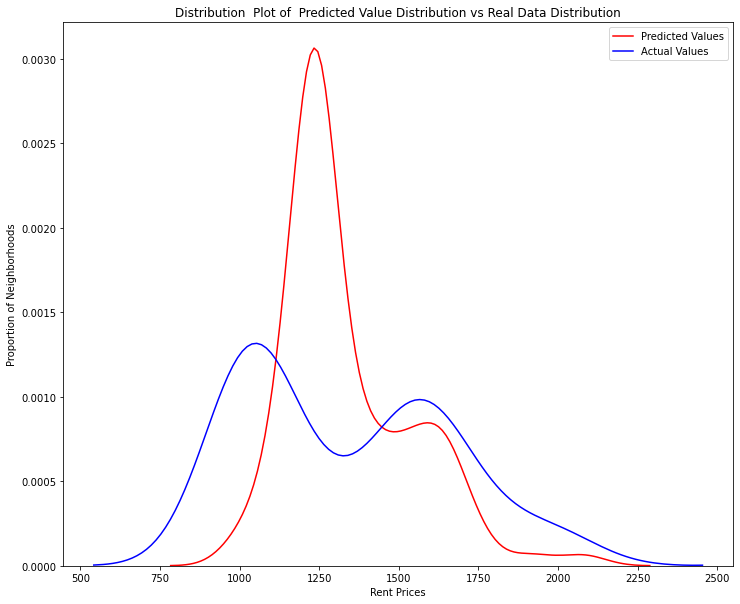

In [374]:
Title = 'Distribution  Plot of  Predicted Value Distribution vs Real Data Distribution'
DistributionPlot(yhat_train, y_train, "Predicted Values", "Actual Values", Title)

The plot above shows the actual rent prices in blue and the predicted rent prices in red. The model seems to preform decently well but overestimates how many moderately priced neighborhoods are in the city, this could be due to the fact that the city of Atlanta has fairly strict and historic divides between resedential neighborhoods and that many of the old, historically wealthy and expensive neighborhoods have fewer venues so most of the venue data come from moderately priced neighborhoods